# Method 6 - Best Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
# Backtest the Portfolio

w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

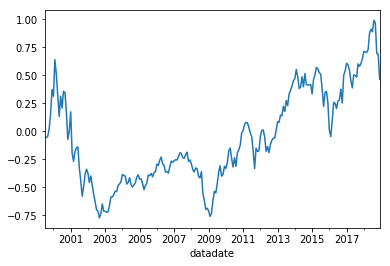

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.372016
2000-12-31   -0.270396
2001-12-31   -0.338367
2002-12-31   -0.565354
2003-12-31    0.912230
2004-12-31    0.111064
2005-12-31    0.045741
2006-12-31    0.131849
2007-12-31    0.028668
2008-12-31   -0.578047
2009-12-31    1.190951
2010-12-31    0.430578
2011-12-31   -0.162407
2012-12-31    0.223298
2013-12-31    0.438703
2014-12-31   -0.023056
2015-12-31   -0.116461
2016-12-31    0.228026
2017-12-31    0.070474
2018-12-31   -0.111902
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     311.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.63e-91
Time:                        14:42:38   Log-Likelihood:                 414.30
No. Observations:                 234   AIC:                            -818.6
Df Residuals:                     229   BIC:                            -801.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      1.008      0.315      -0.003       0.008
mktrf          1.4502      0.078     18.673      0.000       1.297       1.603
me             0.6321      0.090      6.997      0.000       0.454       0.810
ia            -0.0542      0.137     -0.395      0.693      -0.325       0.216
roe           -1.0778      0.118     -9.170      0.000      -1.309      -0.846
==============================================================================
Omnibus:                       57.628   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.542
Skew:                           0.812   Prob(JB):                     4.10e-70
Kurtosis:                       8.489   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     110.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.98e-52
Time:                        14:42:38   Log-Likelihood:                 414.30
No. Observations:                 234   AIC:                            -818.6
Df Residuals:                     229   BIC:                            -801.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      1.127      0.260      -0.002       0.008
mktrf          1.4502      0.121     11.993      0.000       1.213       1.687
me             0.6321      0.104      6.068      0.000       0.428       0.836
ia            -0.0542      0.218     -0.249      0.804      -0.481       0.373
roe           -1.0778      0.234     -4.607      0.000      -1.536      -0.619
==============================================================================
Omnibus:                       57.628   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.542
Skew:                           0.812   Prob(JB):                     4.10e-70
Kurtosis:                       8.489   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     112.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.97e-53
Time:                        14:42:38   Log-Likelihood:                 414.30
No. Observations:                 234   AIC:                            -818.6
Df Residuals:                     229   BIC:                            -801.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      1.077      0.281      -0.002       0.008
mktrf          1.4502      0.131     11.104      0.000       1.194       1.706
me             0.6321      0.114      5.557      0.000       0.409       0.855
ia            -0.0542      0.191     -0.284      0.776      -0.428       0.320
roe           -1.0778      0.254     -4.241      0.000      -1.576      -0.580
==============================================================================
Omnibus:                       57.628   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.542
Skew:                           0.812   Prob(JB):                     4.10e-70
Kurtosis:                       8.489   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     227.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.43e-86
Time:                        14:42:38   Log-Likelihood:                 406.10
No. Observations:                 234   AIC:                            -800.2
Df Residuals:                     228   BIC:                            -779.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.003      0.821      0.412      -0.003       0.008
mktrf          1.5398      0.081     19.064      0.000       1.381       1.699
smb            0.6375      0.107      5.982      0.000       0.428       0.848
hml            0.1458      0.126      1.161      0.247      -0.102       0.393
rmw           -1.0424      0.142     -7.337      0.000      -1.322      -0.762
cma           -0.0023      0.181     -0.013      0.990      -0.358       0.354
==============================================================================
Omnibus:                       74.233   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.228
Skew:                           1.209   Prob(JB):                     4.79e-70
Kurtosis:                       8.186   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     122.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-62
Time:                        14:42:38   Log-Likelihood:                 406.10
No. Observations:                 234   AIC:                            -800.2
Df Residuals:                     228   BIC:                            -779.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.002      0.317      -0.002       0.007
mktrf          1.5398      0.085     18.108      0.000       1.373       1.706
smb            0.6375      0.126      5.078      0.000       0.391       0.884
hml            0.1458      0.235      0.621      0.535      -0.314       0.606
rmw           -1.0424      0.216     -4.829      0.000      -1.466      -0.619
cma           -0.0023      0.312     -0.008      0.994      -0.613       0.609
==============================================================================
Omnibus:                       74.233   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.228
Skew:                           1.209   Prob(JB):                     4.79e-70
Kurtosis:                       8.186   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     135.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.13e-66
Time:                        14:42:38   Log-Likelihood:                 406.10
No. Observations:                 234   AIC:                            -800.2
Df Residuals:                     228   BIC:                            -779.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.003      0.935      0.350      -0.003       0.008
mktrf          1.5398      0.081     19.085      0.000       1.382       1.698
smb            0.6375      0.127      5.013      0.000       0.388       0.887
hml            0.1458      0.195      0.748      0.455      -0.236       0.528
rmw           -1.0424      0.232     -4.489      0.000      -1.498      -0.587
cma           -0.0023      0.266     -0.009      0.993      -0.524       0.519
==============================================================================
Omnibus:                       74.233   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.228
Skew:                           1.209   Prob(JB):                     4.79e-70
Kurtosis:                       8.186   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     289.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.86e-88
Time:                        14:42:38   Log-Likelihood:                 407.14
No. Observations:                 234   AIC:                            -804.3
Df Residuals:                     229   BIC:                            -787.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.123      0.902      -0.006       0.005
mktrf          1.5931      0.074     21.609      0.000       1.448       1.738
smb            1.1254      0.092     12.228      0.000       0.944       1.307
hml           -0.1190      0.091     -1.301      0.194      -0.299       0.061
umd           -0.4414      0.060     -7.359      0.000      -0.560      -0.323
==============================================================================
Omnibus:                       42.785   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.081
Skew:                           0.785   Prob(JB):                     2.29e-26
Kurtosis:                       6.106   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     302.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.88e-90
Time:                        14:42:39   Log-Likelihood:                 407.14
No. Observations:                 234   AIC:                            -804.3
Df Residuals:                     229   BIC:                            -787.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.149      0.882      -0.005       0.004
mktrf          1.5931      0.088     18.133      0.000       1.421       1.765
smb            1.1254      0.075     14.990      0.000       0.978       1.273
hml           -0.1190      0.158     -0.751      0.453      -0.430       0.192
umd           -0.4414      0.111     -3.993      0.000      -0.658      -0.225
==============================================================================
Omnibus:                       42.785   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.081
Skew:                           0.785   Prob(JB):                     2.29e-26
Kurtosis:                       6.106   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     408.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.02e-103
Time:                        14:42:39   Log-Likelihood:                 407.14
No. Observations:                 234   AIC:                            -804.3
Df Residuals:                     229   BIC:                            -787.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.147      0.883      -0.005       0.004
mktrf          1.5931      0.093     17.146      0.000       1.411       1.775
smb            1.1254      0.071     15.790      0.000       0.986       1.265
hml           -0.1190      0.146     -0.814      0.416      -0.405       0.167
umd           -0.4414      0.111     -3.965      0.000      -0.660      -0.223
==============================================================================
Omnibus:                       42.785   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.081
Skew:                           0.785   Prob(JB):                     2.29e-26
Kurtosis:                       6.106   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     145.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.49e-44
Time:                        14:42:39   Log-Likelihood:                 190.31
No. Observations:                 120   AIC:                            -370.6
Df Residuals:                     115   BIC:                            -356.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.005      1.225      0.223      -0.004       0.016
mktrf          1.4390      0.130     11.031      0.000       1.181       1.697
me             0.5153      0.129      4.000      0.000       0.260       0.771
ia            -0.1426      0.202     -0.707      0.481      -0.542       0.257
roe           -1.0677      0.179     -5.979      0.000      -1.421      -0.714
==============================================================================
Omnibus:                       23.508   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.975
Skew:                           0.604   Prob(JB):                     3.18e-17
Kurtosis:                       6.706   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     85.43
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.60e-33
Time:                        14:42:39   Log-Likelihood:                 190.31
No. Observations:                 120   AIC:                            -370.6
Df Residuals:                     115   BIC:                            -356.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.004      1.515      0.130      -0.002       0.014
mktrf          1.4390      0.180      7.985      0.000       1.086       1.792
me             0.5153      0.128      4.022      0.000       0.264       0.766
ia            -0.1426      0.303     -0.471      0.637      -0.735       0.450
roe           -1.0677      0.310     -3.446      0.001      -1.675      -0.460
==============================================================================
Omnibus:                       23.508   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.975
Skew:                           0.604   Prob(JB):                     3.18e-17
Kurtosis:                       6.706   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     91.53
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.17e-35
Time:                        14:42:39   Log-Likelihood:                 190.31
No. Observations:                 120   AIC:                            -370.6
Df Residuals:                     115   BIC:                            -356.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.004      1.546      0.122      -0.002       0.013
mktrf          1.4390      0.196      7.329      0.000       1.054       1.824
me             0.5153      0.141      3.646      0.000       0.238       0.792
ia            -0.1426      0.263     -0.541      0.588      -0.659       0.374
roe           -1.0677      0.343     -3.112      0.002      -1.740      -0.395
==============================================================================
Omnibus:                       23.508   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.975
Skew:                           0.604   Prob(JB):                     3.18e-17
Kurtosis:                       6.706   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     108.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-41
Time:                        14:42:39   Log-Likelihood:                 187.46
No. Observations:                 120   AIC:                            -362.9
Df Residuals:                     114   BIC:                            -346.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.005      1.317      0.190      -0.003       0.017
mktrf          1.6764      0.141     11.849      0.000       1.396       1.957
smb            0.5707      0.160      3.562      0.001       0.253       0.888
hml           -0.1343      0.196     -0.684      0.495      -0.523       0.255
rmw           -0.7971      0.232     -3.442      0.001      -1.256      -0.338
cma            0.1134      0.254      0.447      0.656      -0.389       0.616
==============================================================================
Omnibus:                       41.765   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.906
Skew:                           1.294   Prob(JB):                     1.12e-25
Kurtosis:                       7.035   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     49.28
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.16e-27
Time:                        14:42:39   Log-Likelihood:                 187.46
No. Observations:                 120   AIC:                            -362.9
Df Residuals:                     114   BIC:                            -346.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.003      2.018      0.044       0.000       0.013
mktrf          1.6764      0.142     11.820      0.000       1.398       1.954
smb            0.5707      0.158      3.606      0.000       0.261       0.881
hml           -0.1343      0.237     -0.568      0.570      -0.598       0.329
rmw           -0.7971      0.269     -2.959      0.003      -1.325      -0.269
cma            0.1134      0.368      0.308      0.758      -0.608       0.834
==============================================================================
Omnibus:                       41.765   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.906
Skew:                           1.294   Prob(JB):                     1.12e-25
Kurtosis:                       7.035   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     56.13
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.69e-29
Time:                        14:42:39   Log-Likelihood:                 187.46
No. Observations:                 120   AIC:                            -362.9
Df Residuals:                     114   BIC:                            -346.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.003      2.096      0.036       0.000       0.013
mktrf          1.6764      0.124     13.513      0.000       1.433       1.920
smb            0.5707      0.156      3.663      0.000       0.265       0.876
hml           -0.1343      0.208     -0.647      0.518      -0.541       0.272
rmw           -0.7971      0.302     -2.638      0.008      -1.389      -0.205
cma            0.1134      0.307      0.370      0.712      -0.488       0.714
==============================================================================
Omnibus:                       41.765   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.906
Skew:                           1.294   Prob(JB):                     1.12e-25
Kurtosis:                       7.035   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     156.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-45
Time:                        14:42:39   Log-Likelihood:                 193.98
No. Observations:                 120   AIC:                            -378.0
Df Residuals:                     115   BIC:                            -364.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.005      0.807      0.421      -0.005       0.013
mktrf          1.6498      0.111     14.801      0.000       1.429       1.871
smb            1.0265      0.127      8.089      0.000       0.775       1.278
hml           -0.3090      0.127     -2.431      0.017      -0.561      -0.057
umd           -0.4170      0.078     -5.321      0.000      -0.572      -0.262
==============================================================================
Omnibus:                       26.252   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.672
Skew:                           0.903   Prob(JB):                     3.65e-12
Kurtosis:                       5.697   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     204.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.72e-51
Time:                        14:42:39   Log-Likelihood:                 193.98
No. Observations:                 120   AIC:                            -378.0
Df Residuals:                     115   BIC:                            -364.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.153      0.249      -0.003       0.010
mktrf          1.6498      0.121     13.607      0.000       1.412       1.887
smb            1.0265      0.086     11.994      0.000       0.859       1.194
hml           -0.3090      0.199     -1.550      0.121      -0.700       0.082
umd           -0.4170      0.122     -3.427      0.001      -0.656      -0.179
==============================================================================
Omnibus:                       26.252   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.672
Skew:                           0.903   Prob(JB):                     3.65e-12
Kurtosis:                       5.697   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     240.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.66e-55
Time:                        14:42:39   Log-Likelihood:                 193.98
No. Observations:                 120   AIC:                            -378.0
Df Residuals:                     115   BIC:                            -364.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.216      0.224      -0.002       0.010
mktrf          1.6498      0.130     12.688      0.000       1.395       1.905
smb            1.0265      0.077     13.250      0.000       0.875       1.178
hml           -0.3090      0.192     -1.613      0.107      -0.684       0.066
umd           -0.4170      0.121     -3.439      0.001      -0.655      -0.179
==============================================================================
Omnibus:                       26.252   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.672
Skew:                           0.903   Prob(JB):                     3.65e-12
Kurtosis:                       5.697   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     198.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.03e-49
Time:                        14:42:39   Log-Likelihood:                 244.23
No. Observations:                 114   AIC:                            -478.5
Df Residuals:                     109   BIC:                            -464.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.003      0.383      0.703      -0.005       0.007
mktrf          1.4007      0.085     16.403      0.000       1.231       1.570
me             0.9395      0.132      7.126      0.000       0.678       1.201
ia             0.0434      0.183      0.238      0.813      -0.319       0.406
roe           -1.1510      0.161     -7.162      0.000      -1.469      -0.832
==============================================================================
Omnibus:                       16.826   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.667
Skew:                           0.719   Prob(JB):                     4.40e-06
Kurtosis:                       4.768   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     143.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-42
Time:                        14:42:39   Log-Likelihood:                 244.23
No. Observations:                 114   AIC:                            -478.5
Df Residuals:                     109   BIC:                            -464.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.516      0.606      -0.003       0.005
mktrf          1.4007      0.116     12.066      0.000       1.173       1.628
me             0.9395      0.172      5.452      0.000       0.602       1.277
ia             0.0434      0.213      0.204      0.838      -0.374       0.461
roe           -1.1510      0.216     -5.330      0.000      -1.574      -0.728
==============================================================================
Omnibus:                       16.826   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.667
Skew:                           0.719   Prob(JB):                     4.40e-06
Kurtosis:                       4.768   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     152.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.93e-44
Time:                        14:42:39   Log-Likelihood:                 244.23
No. Observations:                 114   AIC:                            -478.5
Df Residuals:                     109   BIC:                            -464.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.502      0.616      -0.003       0.005
mktrf          1.4007      0.118     11.840      0.000       1.169       1.633
me             0.9395      0.199      4.714      0.000       0.549       1.330
ia             0.0434      0.220      0.198      0.843      -0.387       0.474
roe           -1.1510      0.222     -5.181      0.000      -1.586      -0.716
==============================================================================
Omnibus:                       16.826   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.667
Skew:                           0.719   Prob(JB):                     4.40e-06
Kurtosis:                       4.768   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     154.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.69e-47
Time:                        14:42:39   Log-Likelihood:                 243.14
No. Observations:                 114   AIC:                            -474.3
Df Residuals:                     108   BIC:                            -457.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.003     -0.178      0.859      -0.006       0.005
mktrf          1.4332      0.083     17.351      0.000       1.269       1.597
smb            0.8107      0.134      6.046      0.000       0.545       1.077
hml            0.4264      0.171      2.493      0.014       0.087       0.765
rmw           -1.3147      0.209     -6.278      0.000      -1.730      -0.900
cma           -0.1311      0.266     -0.493      0.623      -0.658       0.396
==============================================================================
Omnibus:                        0.994   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.608   Jarque-Bera (JB):                0.931
Skew:                           0.217   Prob(JB):                        0.628
Kurtosis:                       2.915   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     98.25
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.50e-38
Time:                        14:42:39   Log-Likelihood:                 243.14
No. Observations:                 114   AIC:                            -474.3
Df Residuals:                     108   BIC:                            -457.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.003     -0.192      0.848      -0.006       0.005
mktrf          1.4332      0.085     16.930      0.000       1.267       1.599
smb            0.8107      0.142      5.690      0.000       0.531       1.090
hml            0.4264      0.180      2.371      0.018       0.074       0.779
rmw           -1.3147      0.201     -6.540      0.000      -1.709      -0.921
cma           -0.1311      0.278     -0.471      0.637      -0.676       0.414
==============================================================================
Omnibus:                        0.994   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.608   Jarque-Bera (JB):                0.931
Skew:                           0.217   Prob(JB):                        0.628
Kurtosis:                       2.915   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     99.50
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.60e-39
Time:                        14:42:39   Log-Likelihood:                 243.14
No. Observations:                 114   AIC:                            -474.3
Df Residuals:                     108   BIC:                            -457.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.003     -0.175      0.861      -0.006       0.005
mktrf          1.4332      0.089     16.151      0.000       1.259       1.607
smb            0.8107      0.162      5.001      0.000       0.493       1.128
hml            0.4264      0.149      2.869      0.004       0.135       0.718
rmw           -1.3147      0.180     -7.288      0.000      -1.668      -0.961
cma           -0.1311      0.294     -0.446      0.656      -0.708       0.446
==============================================================================
Omnibus:                        0.994   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.608   Jarque-Bera (JB):                0.931
Skew:                           0.217   Prob(JB):                        0.628
Kurtosis:                       2.915   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     145.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.35e-43
Time:                        14:42:39   Log-Likelihood:                 228.86
No. Observations:                 114   AIC:                            -447.7
Df Residuals:                     109   BIC:                            -434.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.003     -0.628      0.532      -0.009       0.004
mktrf          1.4910      0.093     16.101      0.000       1.308       1.675
smb            1.1117      0.144      7.699      0.000       0.826       1.398
hml            0.4279      0.149      2.877      0.005       0.133       0.723
umd           -0.3506      0.112     -3.125      0.002      -0.573      -0.128
==============================================================================
Omnibus:                        4.571   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.306
Skew:                           0.311   Prob(JB):                        0.116
Kurtosis:                       3.721   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     133.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.93e-41
Time:                        14:42:39   Log-Likelihood:                 228.86
No. Observations:                 114   AIC:                            -447.7
Df Residuals:                     109   BIC:                            -434.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.003     -0.754      0.451      -0.007       0.003
mktrf          1.4910      0.100     14.860      0.000       1.294       1.688
smb            1.1117      0.146      7.604      0.000       0.825       1.398
hml            0.4279      0.186      2.296      0.022       0.063       0.793
umd           -0.3506      0.115     -3.036      0.002      -0.577      -0.124
==============================================================================
Omnibus:                        4.571   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.306
Skew:                           0.311   Prob(JB):                        0.116
Kurtosis:                       3.721   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     167.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.45e-45
Time:                        14:42:39   Log-Likelihood:                 228.86
No. Observations:                 114   AIC:                            -447.7
Df Residuals:                     109   BIC:                            -434.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.003     -0.741      0.459      -0.008       0.003
mktrf          1.4910      0.104     14.349      0.000       1.287       1.695
smb            1.1117      0.140      7.947      0.000       0.838       1.386
hml            0.4279      0.167      2.562      0.010       0.101       0.755
umd           -0.3506      0.119     -2.946      0.003      -0.584      -0.117
==============================================================================
Omnibus:                        4.571   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.306
Skew:                           0.311   Prob(JB):                        0.116
Kurtosis:                       3.721   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""